# ResNet Detector Developement 1

WNixalo - 1:7/5/2018

---

The purpose of this notebook is to experiment with small datasets (CPU dev) and finetune the general-purpose base object detector on the GLoC dataset.

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *

sys.path.insert(1, os.path.join('../'))
from utils import common
from utils import temp_utils
from utils.subfolder_val_idxs import set_val_idxs

from matplotlib import patches, patheffects

In [3]:
PATH = Path('../data')
PATH_IMAGES   = PATH/'train'
PATH_CLAS_CSV = PATH/'class_labels.csv'
PATH_BBOX_CSV = PATH/'bbox_labels.csv'

# PATH_TRAIN_BBX = PATH/'interstage_train'
# CPU_PATH_CSV     = PATH/'cpu_labels.csv'
# CPU_PATH_CSV_BBX = PATH/'cpu_interstage_labels.csv'

## TEMP

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt, 
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1], a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)
        
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH / trn_fns[i])
    draw_im(im, im_a)

In [5]:
MC_CSV = PATH_CLAS_CSV

In [6]:
df = pd.read_csv(MC_CSV)
# df.head()
classes = df['class'].values
classes = np.array([('OK','GLOC')[clas] for clas in classes])
df = df.drop(columns='class')
df.insert(1, 'class', classes)
df.to_csv(PATH/'temp_class_labels.csv', index=False)

TMP_MC_CSV = PATH/'temp_class_labels.csv'

In [39]:
df = pd.read_csv(MC_CSV)

In [41]:
set(df['class'].values)

{0}

In [7]:
list(PATH.iterdir())

[PosixPath('../data/cpu_interstage_labels.csv'),
 PosixPath('../data/labels.csv'),
 PosixPath('../data/.DS_Store'),
 PosixPath('../data/class_bbox_labels.csv'),
 PosixPath('../data/labels'),
 PosixPath('../data/models'),
 PosixPath('../data/test_z'),
 PosixPath('../data/interstage_train'),
 PosixPath('../data/train'),
 PosixPath('../data/cpu_labels.csv'),
 PosixPath('../data/interstage_labels_v1.csv'),
 PosixPath('../data/temp_class_labels.csv'),
 PosixPath('../data/class_labels.csv'),
 PosixPath('../data/bbox_labels.csv'),
 PosixPath('../data/tmp')]

In [44]:
df = pd.read_csv(PATH/'class_bbox_labels.csv')
df.head()

,id,bbox,class
0,000000-000412/000000.jpg,83 72 191 380,pilot
1,000000-000412/000001.jpg,52 89 204 381,pilot
2,000000-000412/000002.jpg,58 89 208 390,pilot
3,000000-000412/000003.jpg,66 98 214 388,pilot
4,000000-000412/000004.jpg,65 90 209 389,pilot


In [8]:
f_model = resnet34
sz = 128
bs=16

In [9]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md   = ImageClassifierData.from_csv(PATH, PATH_IMAGES, TMP_MC_CSV, tfms=tfms, bs=bs)

In [33]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

epoch      trn_loss   val_loss   accuracy                
    0      0.0        0.0        1.0       



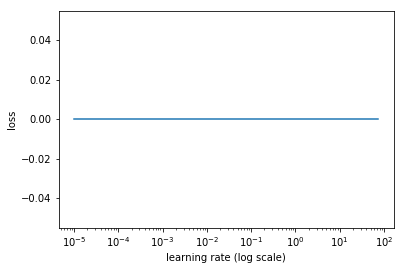

In [34]:
lrf = learn.lr_find(1e-5, 100)
learn.sched.plot(0)

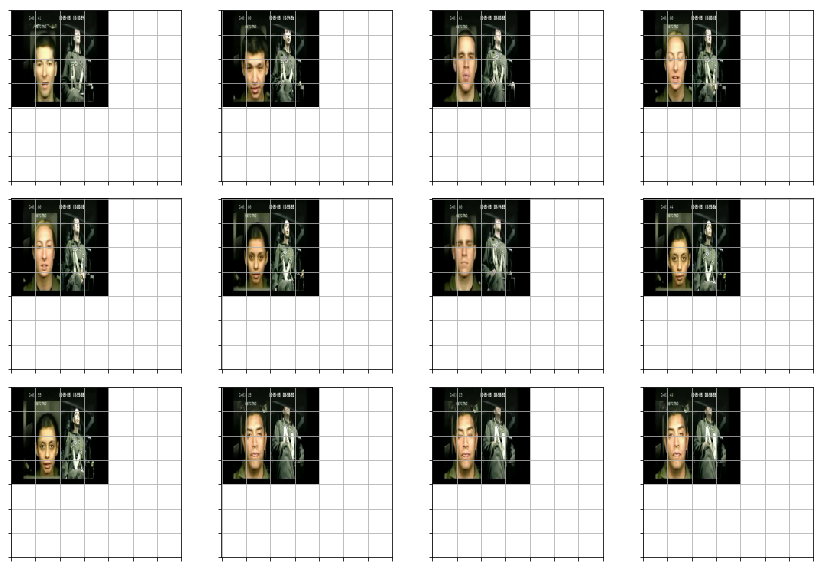

In [35]:
# y = learn.predict()
# x,_ = next(iter(md.val_dl))
# x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i] > 0.0)[0] # find actvn above a threshold
    b  = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

In [36]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

## 1. Data

In [46]:
df = pd.read_csv(PATH_BBOX_CSV)
df.head()

,id,bbox
0,000000-000412/000000.jpg,72 83 380 191
1,000000-000412/000001.jpg,89 52 381 204
2,000000-000412/000002.jpg,89 58 390 208
3,000000-000412/000003.jpg,98 66 388 214
4,000000-000412/000004.jpg,90 65 389 209


### CPU data subset - TODO

***NOTE***: I'll have to rewrite my validation set indexer to work with CSVs instead of directories.

In [4]:
# TODO

### Visualizations - TODO

In [93]:
bbx = cpu_bbx_df.iloc[0].values[1:5]; bbx

array([148, 130, 246, 386], dtype=object)

In [379]:
def show_img(img, bbx, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(bbx):
    """returns (h w) from  (x1 y1 x2 y2) bounding box"""
    h = bbx[3]-bbx[1]
    w = bbx[2]-bbx[0]
    return h,w

def draw_outline(o, λw):
    o.set_path_effects([patheffects.Stroke(linewidth=λw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, bbx):
    # draw bounding box
    h,w = bb_hw(bbx)
    patch = ax.add_patch(patches.Rectangle(bbx[:2], w,h, fill=False, edgecolor='white', lw=2)) # *bbx[:2] destructs bbx giving bbx[-2], bbx[-1]
    # outline it
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    # draw classification
    text = ax.text(*xy, 'Pilot', verticalalignment='top', color='white', fontsize=sz, weight='bold')
    # outline it
    draw_outline(text, 1)
    
def display_anno(img, bbx, clsfn=None):
    ax = show_img(img, bbx)
    draw_rect(ax, bbx)
    draw_text(ax, bbx[:2], clsfn)

### fastai ModelData Object

In [4]:
f_model = resnet34
sz = 224
bs = 32

In [42]:
df_mbb = pd.read_csv(PATH_BBOX_CSV)
df_mcs = pd.read_csv(PATH_CLAS_CSV)

trn_fns = df_mbb['id'].values
mcs  = df_mcs['class'].values
mbbs = df_mbb['bbox'].values

In [43]:
mcs

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
mcs = [np.array([c]) for c in mcs]

In [46]:
np.array(mcs)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [47]:
mcs = np.array(mcs)

In [48]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [60]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD), 
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD), 
            RandomFlip(tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
model_data = ImageClassifierData.from_csv(PATH, PATH_IMAGES, PATH_BBOX_CSV, bs=bs, tfms=tfms, continuous=True)

#### Adding Class labels to Coordinate labels

In [61]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds, y2
        self.sz = ds.sz
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, self.y2[i]))

In [62]:
len(model_data.val_dl.dataset.fnames)

1527

In [63]:
len(model_data.trn_dl.dataset.fnames)

6110

In [64]:
1527 / 6110

0.24991816693944355

Wow. The fastai library automatically sets a random validation set of 25% of your data if you don't specify any. Cool.

In [65]:
len(trn_mcs)

6110

In [66]:
len(val_mcs)

1527

In [67]:
trn_ds2 = ConcatLblDataset(model_data.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(model_data.val_ds, val_mcs)

model_data.trn_dl.dataset = trn_ds2
model_data.val_dl.dataset = val_ds2

In [7]:
# df_mcs = pd.read_csv(PATH_CLAS_CSV)
# multi_classes = np.array([np.array([clasid]) for clasid in df_mcs['class']])

# trn2 = ConcatLblDataset(model_data.trn_ds, multi_classes)
# model_data.trn_dl.dataset = trn2

In [17]:
len(model_data.trn_dl.dataset.fnames)

AttributeError: 'ConcatLblDataset' object has no attribute 'fnames'

In [38]:
x,y = to_np(next(iter(model_data.trn_dl)))
x = model_data.trn_ds.ds.denorm(x)

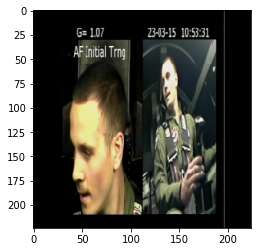

In [40]:
plt.imshow(x[0])

In [8]:
model_data.trn_dl.dataset[0]

(array([[[-1.83673, -1.83673, -1.83673, ..., -1.83673, -1.83673, -1.83673],
         [-2.0075 , -2.0075 , -2.0075 , ..., -2.0075 , -2.0075 , -2.0075 ],
         [-2.0075 , -2.0075 , -2.0075 , ..., -2.0075 , -2.0075 , -2.0075 ],
         ...,
         [-2.0075 , -2.0075 , -2.0075 , ..., -2.0075 , -2.0075 , -2.0075 ],
         [-2.0075 , -2.0075 , -2.0075 , ..., -2.0075 , -2.0075 , -2.0075 ],
         [-2.0075 , -2.0075 , -2.0075 , ..., -2.0075 , -2.0075 , -2.0075 ]],
 
        [[-1.74826, -1.74826, -1.74826, ..., -1.74826, -1.74826, -1.74826],
         [-1.92285, -1.92285, -1.92285, ..., -1.92285, -1.92285, -1.92285],
         [-1.92285, -1.92285, -1.92285, ..., -1.92285, -1.92285, -1.92285],
         ...,
         [-1.92285, -1.92285, -1.92285, ..., -1.92285, -1.92285, -1.92285],
         [-1.92285, -1.92285, -1.92285, ..., -1.92285, -1.92285, -1.92285],
         [-1.92285, -1.92285, -1.92285, ..., -1.92285, -1.92285, -1.92285]],
 
        [[-1.51827, -1.51827, -1.51827, ..., -1.51827,

Another check that I did things right, by making sure I can pull out a piece of data and view it:

In [20]:
tmep = next(iter(model_data.trn_dl))[0]

In [26]:
x = model_data.val_ds.denorm(to_np(tmep[0]))

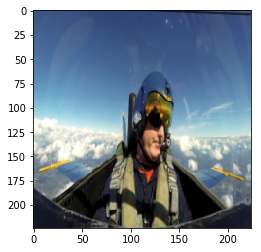

In [31]:
plt.imshow(x[0])

***NOTE***: I wonder if this will be an issue though:

In [34]:
model_data.trn_ds

In [33]:
model_data.val_ds

## 2. Architecture

In [68]:
anc_grid = 4
k = 1
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors  = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

def hw2corners(ctr, hw): return torch.cat([ctr - hw/2, ctr + hw/2], dim=1)

anchor_cnr = hw2corners(anchors[:, :2], anchors[:, 2:])

In [69]:
n_clas = 1 + 1
k = 1

class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf // k)


class OutConv(nn.Module): # 2 separate output conv layers: bbx reg & clsfn
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, n_clas*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k), 
                flatten_conv(self.oconv2(x), self.k)]

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)
    
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn  = ConvLearner(model_data, models)
learn.opt_fn = optim.Adam

In [82]:
n_clas

2

## ** `LOSS FUNCTION` **

In [74]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, pred, targ):
#         print(targ)
#         raise Error

#         pdb.set_trace()

        t = one_hot_embedding(targ, self.num_classes + 1)
        t = V(t[:, :-1].contiguous()).cpu() # remove last col (bg)
#         print(t)
        x = pred[:, :-1]
    
#         print(t)
        
#         print('-------------------------------------------')
    
#         print(x)
    
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self, x, t): return None

# loss_f = BCE_Loss(n_clas)

loss_f = BCE_Loss(n_clas - 1) # the 'actual' num classes, NOT including 'bg'

def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox, clas): # strip fastai zero padding
    bbox = bbox.view(-1, 4) / sz
    bb_keep = ((bbox[:,2] - bbox[:,0]) > 0).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:, :2] / 2 * grid_sizes) + anchors[:, :2]
#     pdb.set_trace()
    actn_hw = (actn_bbs[:, 2:] / 2 + 1) * anchors[:, 2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False): # calc ssd loss for 1 img
    
    try:
        bbox,clas = get_y(bbox,clas)
    except IndexError as e:
        print(e)
        pdb.set_trace()
    
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors) # cnvt activations to bboxs
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:, 0] # find what matches
    gt_clas[1 - pos] = n_clas-1 # asign bg class
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean() # L1 loss
    
#     pdb.set_trace()
    
    clas_loss = loss_f(b_c, gt_clas) # BCE loss
    return loc_loss, clas_loss

def ssd_loss(pred, targ, print_it=False):
    λcs,λλs = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ): # loop thru ea. img in minibatch
        
        
        
        loc_loss,clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        λλs += loc_loss
        λcs += clas_loss
    if print_it: print(f'loc: {λλs.data[0]}, clas: {λcs.data[0]}')
    return λλs+λcs

In [75]:
learn.crit = ssd_loss

In [76]:
learn.lr_find()
learn.sched.plot()

  1%|          | 2/191 [00:23<37:14, 11.82s/it, loss=126]  trying to index 2 dimensions of a 0 dimensional tensor
> <ipython-input-74-fa68de00b22d>(76)ssd_1_loss()
-> bbox,clas = get_y(bbox,clas)
(Pdb) bbox
Variable containing:
 0
 0
 0
 0
[torch.FloatTensor of size 4]

(Pdb) clas
Variable containing:
 0
[torch.LongTensor of size 1]

(Pdb) bbox.view(-1, 4) / sz
Variable containing:
 0  0  0  0
[torch.FloatTensor of size 1x4]

(Pdb) ((bbox[:,2] - bbox[:,0]) > 0)
*** IndexError: trying to index 2 dimensions of a 1 dimensional tensor
(Pdb) (((bbox.view(-1, 4) / sz)[:,2] - (bbox.view(-1, 4) / sz)[:,0]) > 0).nonzero()[:,0]
*** IndexError: trying to index 2 dimensions of a 0 dimensional tensor
(Pdb) pred
*** NameError: name 'pred' is not defined
(Pdb) b_c
Variable containing:
-2.8890 -3.0718
-2.9243 -2.8790
-2.9574 -2.9914
-3.2032 -2.7053
-3.3724 -3.5135
-3.1493 -3.1642
-3.2808 -3.6575
-2.9938 -3.3793
-2.9358 -3.3240
-3.4151 -3.1329
-2.6038 -3.0144
-2.7668 -2.6808
-3.1179 -3.1958
-3.1516 -2.

BdbQuit: 

In [73]:
%debug

> /Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torch/autograd/_functions/tensor.py(89)forward()
     87             result = i.index(ctx.index)
     88         else:
---> 89             result = i.index(ctx.index)
     90             ctx.mark_shared_storage((i, result))
     91         return result

ipdb> q


In [17]:
learn.lr_find()
learn.sched.plot()

  1%|          | 1/191 [00:14<46:37, 14.72s/it, loss=122]trying to index 2 dimensions of a 0 dimensional tensor
> <ipython-input-15-24eae94928c8>(77)ssd_1_loss()
-> a_ic = actn_to_bb(b_bb, anchors) # cnvt activations to bboxs
(Pdb) bbox
Variable containing:
 0
 0
 0
 0
[torch.FloatTensor of size 4]

(Pdb) clas
Variable containing:
 0
[torch.LongTensor of size 1]

(Pdb) l
 72  	    except IndexError as e:
 73  	        print(e)
 74  	        pdb.set_trace()
 75  	
 76  	#     bbox,clas = get_y(bbox,clas)
 77  ->	    a_ic = actn_to_bb(b_bb, anchors) # cnvt activations to bboxs
 78  	    overlaps = jaccard(bbox.data, anchor_cnr.data)
 79  	    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
 80  	    gt_clas = clas[gt_idx]
 81  	    pos = gt_overlap > 0.4
 82  	    pos_idx = torch.nonzero(pos)[:, 0] # find what matches
(Pdb) b_bb
Variable containing:
 0.0279 -0.1364 -0.1095 -0.0141
-0.1691  0.0732 -0.6103  0.6824
 0.9597 -0.0764 -0.3365  0.5768
 0.0774 -0.0164  0.3717  0.2654
 

BdbQuit: 

In [19]:
# model_data.classes

In [20]:
%debug

> /Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/bdb.py(70)dispatch_line()
     68         if self.stop_here(frame) or self.break_here(frame):
     69             self.user_line(frame)
---> 70             if self.quitting: raise BdbQuit
     71         return self.trace_dispatch
     72 

ipdb> clas
*** NameError: name 'clas' is not defined
ipdb> q


In [90]:
%debug

> /Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py(1227)binary_cross_entropy_with_logits()
   1225     """
   1226     if not (target.size() == input.size()):
-> 1227         raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
   1228 
   1229     max_val = (-input).clamp(min=0)

ipdb> l
   1222          >>> target = autograd.Variable(torch.FloatTensor(3).random_(2))
   1223          >>> loss = F.binary_cross_entropy_with_logits(input, target)
   1224          >>> loss.backward()
   1225     """
   1226     if not (target.size() == input.size()):
-> 1227         raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
   1228 
   1229     max_val = (-input).clamp(min=0)
   1230     loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
   1231 
   1232     if weight is not None:

ipdb> num_classes +

In [86]:
%debug

> <ipython-input-83-db15f5ff6c24>(2)one_hot_embedding()
      1 def one_hot_embedding(labels, num_classes):
----> 2     return torch.eye(num_classes)[labels.data.cpu()]
      3 
      4 class BCE_Loss(nn.Module):
      5     def __init__(self, num_classes):

ipdb> labels.data.cpu()

 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 0
 2
 2
 2
 2
 2
[torch.LongTensor of size 16]

ipdb> num_classes
2
ipdb> targ
*** NameError: name 'targ' is not defined
ipdb> l
      1 def one_hot_embedding(labels, num_classes):
----> 2     return torch.eye(num_classes)[labels.data.cpu()]
      3 
      4 class BCE_Loss(nn.Module):
      5     def __init__(self, num_classes):
      6         super().__init__()
      7         self.num_classes = num_classes
      8 
      9     def forward(self, pred, targ):
     10 #         print(targ)
     11 #         raise Error

ipdb> torch.eye(2)

 1  0
 0  1
[torch.FloatTensor of size 2x2]

ipdb> torch.eye(num_classes)[labels.data.cpu()]
*** RuntimeError: index out of range at /Users

In [70]:
n_clas

2

In [68]:
# learn = ConvLearner.pretrained(f_model, model_data, metrics=[accuracy])
# learn.opt_fn = optim.Adam

In [60]:
temp = np.zeros((16,2))
temp = Variable(torch.from_numpy(temp))

In [61]:
temp[:,:-1]

Variable containing:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
[torch.DoubleTensor of size 16x1]

In [62]:
V(temp[:, :-1].contiguous())

Variable containing:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
[torch.DoubleTensor of size 16x1]

In [63]:
temp[:,0].shape

torch.Size([16])

In [69]:
learn.lr_find()
learn.sched.plot()

  0%|          | 0/191 [00:00<?, ?it/s]
> <ipython-input-65-b886e94434dd>(15)forward()
-> t = one_hot_embedding(targ, self.num_classes + 1)
(Pdb) targ
Variable containing:
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 0
 2
 2
 2
 2
 2
[torch.LongTensor of size 16]

(Pdb) one_hot_embedding(targ, self.num_classes + 1)

    0     0     1
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    1     0     0
    0     0     1
    0     0     1
    0     0     1
    0     0     1
    0     0     1
[torch.FloatTensor of size 16x3]

(Pdb) self.num_classes
2
(Pdb) q


BdbQuit: 

In [64]:
learn.lr_find()
learn.sched.plot()

  0%|          | 0/191 [00:00<?, ?it/s]
Variable containing:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    1
    0
    0
    0
    0
    0
    0
[torch.FloatTensor of size 16x1]

-------------------------------------------
Variable containing:
-2.8033
-2.7171
-3.2641
-2.8134
-2.7570
-2.5477
-2.7175
-2.4817
-3.0243
-3.1837
-3.1538
-2.8750
-2.8162
-2.9475
-2.8952
-3.5481
[torch.FloatTensor of size 16x1]

Variable containing:
    0
    0
    0
    0
    0
    0
    1
    0
    0
    0
    0
    0
    0
    0
    0
    0
[torch.FloatTensor of size 16x1]

-------------------------------------------
Variable containing:
-2.8134
-3.3325
-2.9569
-3.5008
-3.1219
-3.1944
-3.3335
-2.7397
-3.0538
-3.0049
-2.8690
-2.5301
-3.5333
-3.6234
-3.4066
-3.1121
[torch.FloatTensor of size 16x1]

Variable containing:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    1
    0
    0
    0
    0
    0
    0
[torch.FloatTensor of size 16x1]

-------------------------------------------
Variable 

Variable containing:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    1
    0
    0
    0
    0
    0
    0
[torch.FloatTensor of size 16x1]

-------------------------------------------
Variable containing:
-3.1222
-2.9990
-3.1460
-3.0671
-2.8089
-2.6776
-3.1535
-2.9870
-2.9922
-3.2089
-2.7170
-2.5141
-3.0984
-2.5877
-2.6786
-3.2843
[torch.FloatTensor of size 16x1]

Variable containing:
    0
    0
    0
    0
    0
    1
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
[torch.FloatTensor of size 16x1]

-------------------------------------------
Variable containing:
-3.1359
-3.0299
-3.0678
-3.1628
-2.9734
-3.2548
-2.9090
-3.1278
-2.7963
-3.0112
-3.4446
-2.9220
-2.9047
-2.9628
-3.0859
-2.9921
[torch.FloatTensor of size 16x1]

Variable containing:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    1
    0
[torch.FloatTensor of size 16x1]

-------------------------------------------
Variable containing:
-3.0135
-3.0873
-3.1414
-3.1

KeyboardInterrupt: 

In [72]:
%debug

> /Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py(1227)binary_cross_entropy_with_logits()
   1225     """
   1226     if not (target.size() == input.size()):
-> 1227         raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
   1228 
   1229     max_val = (-input).clamp(min=0)

ipdb> input
Variable containing:
-2.7156
-2.9716
-2.6522
-3.1248
-3.2871
-3.6609
-3.0220
-2.7267
-3.4537
-3.6158
-3.1740
-2.9266
-2.8807
-3.1247
-2.8776
-2.8890
[torch.FloatTensor of size 16x1]

ipdb> target
Variable containing:
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    1     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
[torch.FloatTensor of size 16x2]

ipdb> q


In [ ]:
class ConvBlock

In [ ]:
class SSD_Head(nn.Module):
    ## TODO

## 3. Loss Function

## 4. Training